In [227]:
#Librerias

import pandas as pd
import os
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
import pickle
%matplotlib inline

### Importación de Data

In [228]:
path = os.path.abspath(os.getcwd()) + r'\Data'

#Base: entrenamiento_precios_vivienda.xlsx
df_train = pd.read_excel(path+r'\entrenamiento_precios_vivienda.xlsx')

In [229]:
df_train.head()

fecha_aprobación       objeto                           motivo  \
0      42979.325078  Originación  Crédito hipotecario de vivienda   
1      42979.330117  Originación                         Garantía   
2      42979.333569  Originación  Crédito hipotecario de vivienda   
3      42979.339908  Originación  Crédito hipotecario de vivienda   
4      42979.354678  Originación  Crédito hipotecario de vivienda   

              proposito  tipo_avaluo tipo_credito tipo_subsidio  \
0  Garantía Hipotecaria  Hipotecario     Vivienda           NaN   
1  Garantía Hipotecaria  Hipotecario     Vivienda           VIS   
2  Garantía Hipotecaria  Hipotecario     Vivienda           NaN   
3  Garantía Hipotecaria  Hipotecario     Vivienda           NaN   
4  Garantía Hipotecaria  Hipotecario     Vivienda           NaN   

  departamento_inmueble municipio_inmueble            barrio  sector  \
0          CUNDINAMARCA             SOACHA      BUENOS AIRES  Urbano   
1                 SUCRE          SINCELEJO        LAS FLORES  Urbano   
2       VALLE DEL CAUCA               CALI  FLORA INDUSTRIAL  Urbano   
3                NARIÑO              PASTO        LAS BRISAS  Urbano   
4       VALLE DEL CAUCA              TULUA      BUENOS AIRES  Urbano   

                direccion_inmueble_informe alcantarillado_en_el_sector  \
0             "KR 7 C # 2 A - 30 SUR CS 2"                          Si   
1                          "KR 6 # 6 - 20"                          Si   
2                  "KR 7 # 58 - 05 AP 201"                          Si   
3  "KR 18 Este # 21 G Bis - 03 MZ 16 CS 1"                          Si   
4                       "CL 26 D # 8 - 27"                          Si   

  acueducto_en_el_sector gas_en_el_sector energia_en_el_sector  \
0                     Si               Si                   Si   
1                     Si               Si                   Si   
2                     Si               Si                   Si   
3                     Si               Si                   Si   
4                     Si               Si                   Si   

  telefono_en_el_sector vias_pavimentadas sardineles_en_las_vias  \
0                    Si                Si                     Si   
1                    Si                Si                     Si   
2                    Si                Si                     Si   
3                    Si                No                     No   
4                    Si                No                     No   

  andenes_en_las_vias estrato barrio_legal topografia_sector  \
0                  Si       2           Si             Plano   
1                  Si       2           Si             Plano   
2                  Si       3           Si             Plano   
3                  Si       2           Si             Plano   
4                  Si       3           Si             Plano   

  condiciones_salubridad transporte demanda_interes paradero alumbrado  \
0                 Buenas      Bueno           Media       Si        Si   
1                 Buenas      Bueno           Media       No        Si   
2                 Buenas      Bueno           Media       Si        Si   
3                 Buenas      Bueno           Media       Si        Si   
4                 Buenas      Bueno           Media       No        Si   

  arborizacion alamedas ciclo_rutas nivel_equipamiento_comercial  \
0           Si       Si          Si                        Bueno   
1           Si       No          No                        Bueno   
2           Si       No          No                    Muy bueno   
3           No       No          No                        Bueno   
4           Si       No          No                 Regular Malo   

                          descripcion_general_sector  \
0  "Vivienda multifamiliar-zonas verdes-arborizac...   
1  "El sector donde se localiza el inmueble es de...   
2                 "Sector consolidado de la ciudad."   
3  "El Barrio Las Brisas es un sector 

### Procesamiento de Data

In [230]:
#Sumarizacion de datos

print("Rows     : ", df_train.shape[0])
print("Columns  : ", df_train.shape[1])
print("\nFeatures : \n", df_train.columns.tolist())
print("\nMissing values :  ", df_train.isnull().sum().values.sum())
print("\nUnique values :  \n", df_train.nunique())

Rows     :  12857
Columns  :  221

Features : 
 ['fecha_aprobación', 'objeto', 'motivo', 'proposito', 'tipo_avaluo', 'tipo_credito', 'tipo_subsidio', 'departamento_inmueble', 'municipio_inmueble', 'barrio', 'sector', 'direccion_inmueble_informe', 'alcantarillado_en_el_sector', 'acueducto_en_el_sector', 'gas_en_el_sector', 'energia_en_el_sector', 'telefono_en_el_sector', 'vias_pavimentadas', 'sardineles_en_las_vias', 'andenes_en_las_vias', 'estrato', 'barrio_legal', 'topografia_sector', 'condiciones_salubridad', 'transporte', 'demanda_interes', 'paradero', 'alumbrado', 'arborizacion', 'alamedas', 'ciclo_rutas', 'nivel_equipamiento_comercial', 'descripcion_general_sector', 'perspectivas_de_valorizacion', 'actualidad_edificadora', 'comportamiento_oferta_demanda', 'alcantarillado_en_el_predio', 'acueducto_en_el_predio', 'gas_en_el_predio', 'energia_en_el_predio', 'telefono_en_el_predio', 'tipo_inmueble', 'descripcion_tipo_inmueble', 'uso_actual', 'descripcion_uso_inmueble', 'clase_inmueble

In [231]:
# Remover duplicados de la base de entrenamiento.

df_dupli = df_train.duplicated(subset=None, keep="first")
df_train = df_train[~df_dupli]

In [232]:
def campos_nan(df_train):
    try:
        campos = []
        obj = df_train.isnull().sum()
        for key,value in obj.iteritems():
            if value > 0:        
                campos.append(key)
            
        if len(campos) > 0:    
            print("\nCampos donde se encontraron registros nan \n {}".format(campos))
            #Caracteristicas con campos NaN o N/A
            df_nan = df_train[campos]
            for col in df_nan.columns.tolist():
                print('\nValores del campo {}:\n'.format(col))
                print(df_nan[col].unique()[:10]) 
        else:
            print("No se encontraron campos con registros nan.")
    except Exception as e:
        print("Puede servir para encontrar el error: {}".format(e))

In [233]:
#Detectar Columas con valores NaN o N/A en la caracterisitcas de la data
campos_nan(df_train) 


Campos donde se encontraron registros nan 
 ['fecha_aprobación', 'tipo_subsidio', 'barrio', 'sector', 'descripcion_tipo_inmueble', 'descripcion_uso_inmueble', 'descripcion_clase_inmueble', 'area_actividad', 'observaciones_estructura', 'observaciones_dependencias', 'numero_garaje_1', 'numero_garaje_2', 'garaje_cubierto_2', 'matricula_garaje_5', 'matricula_inmobiliaria_deposito_3', 'matricula_inmobiliaria_deposito_4', 'observaciones_generales_construccion', 'Latitud']

Valores del campo fecha_aprobación:

[42979.32507828 42979.33011716 42979.33356931 42979.33990774
 42979.35467771 42979.36107943 42979.36269347 42979.37688039
 42979.38416193 42979.39803003]

Valores del campo tipo_subsidio:

[nan 'VIS' 'Frech II' 'Gratuita' 'VIP' 'Vivienda']

Valores del campo barrio:

['BUENOS AIRES' 'LAS FLORES' 'FLORA INDUSTRIAL' 'LAS BRISAS'
 'VIVIENDAS DEL SUR' 'EL BOSQUE' 'La Esperanza' 'LOS ROSALES'
 'CARMENZA ROCHA' 'Condominio Villas del campo']

Valores del campo sector:

['Urbano' 'Rural' 'Mes

A partir de la información, presente en cada uno de los campo que contienen registros nan, procedemos a realizar las siguientes imputaciones. 

In [234]:
#Imputaciones
valores = {
    "fecha_aprobación": df_train['fecha_aprobación'].mode()[0],
    "barrio": "No barrio",
    "sector": "No sector",
    "descripcion_tipo_inmueble": "Sin descripcion tipo",
    "descripcion_uso_inmueble": "Sin descripcion uso",
    "descripcion_clase_inmueble": "Sin descripcion clase",
    "area_actividad": "No area",
    "observaciones_estructura": "No hay observaciones de estructura",
    "observaciones_dependencias": "No hay observaciones dependencias",
    "numero_garaje_1": "No",
    "numero_garaje_2": "No", 
    "garaje_cubierto_2": "No", 
    "matricula_garaje_5": 0,
    "matricula_inmobiliaria_deposito_3": 0,
    "matricula_inmobiliaria_deposito_4": 0, 
    "observaciones_generales_construccion": "Sin observacion de construccion", 
    "Latitud": 0,
    "tipo_subsidio": "No subsidio"
}

df_train.fillna(value=valores, inplace=True)

In [235]:
#Validamos si aun hay datos nulos.
campos_nan(df_train) 

No se encontraron campos con registros nan.


Podemos ver en el procesamiento de la informacion que algunos campos, se etiquetaron de manera incorrecta como el caso de **tipo_subsidio** que al no tener vinculado un subsidio para el inmueble este es etiquetado como nan. Tambien podemos observar en el campo **area_actividad** cadenas de texto y numericas sin conservar una estructura que facilite su interpretación y mas bien da una apariencia de un campo abierto. 

### Analisis Exploratorio

In [236]:
pd.set_option("display.max_columns", None)
df_train.describe()

fecha_aprobación   bano_social  bano_servicio        cocina  \
count      1.285700e+04  12857.000000   12857.000000  12857.000000   
mean       4.323941e+04      1.021778       0.136579      1.065879   
std        1.404839e+04      0.753539       0.377717      0.423449   
min        4.297933e+04      0.000000       0.000000      0.000000   
25%        4.306168e+04      1.000000       0.000000      1.000000   
50%        4.315700e+04      1.000000       0.000000      1.000000   
75%        4.315700e+04      1.000000       0.000000      1.000000   
max        1.636029e+06     14.000000      11.000000     13.000000   

            estudio        balcon       terraza  patio_interior        jardin  \
count  12857.000000  12857.000000  12857.000000    12857.000000  12857.000000   
mean       0.245469      0.510695      0.211947        0.382204      0.063156   
std        0.440563      0.663919      0.465473        0.587005      0.252664   
min        0.000000      0.000000      0.000000        0.000000      0.000000   
25%        0.000000      0.000000      0.000000        0.000000      0.000000   
50%        0.000000      0.000000      0.000000        0.000000      0.000000   
75%        0.000000      1.000000      0.000000        1.000000      0.000000   
max        3.000000     11.000000      9.000000       11.000000      4.000000   

       zona_de_ropas  zona_verde_privada         local       oficina  \
count   12857.000000        12857.000000  12857.000000  12857.000000   
mean        0.965311            0.052501      0.026134      0.010967   
std         0.477767            0.231597      0.208190      0.201784   
min         0.000000            0.000000      0.000000      0.000000   
25%         1.000000            0.000000      0.000000      0.000000   
50%         1.000000            0.000000      0.000000      0.000000   
75%         1.000000            0.000000      0.000000      0.000000   
max        13.000000            4.000000     10.000000      9.000000   

             bodega  numero_garaje_5  matricula_garaje_5  \
count  12857.000000     12857.000000             12857.0   
mean       0.018745         0.002411                 0.0   
std        0.147179         0.273396                 0.0   
min        0.000000         0.000000                 0.0   
25%        0.000000         0.000000                 0.0   
50%        0.000000         0.000000                 0.0   
75%        0.000000         0.000000                 0.0   
max        3.000000        31.000000                 0.0   

       matricula_inmobiliaria_deposito_3  matricula_inmobiliaria_deposito_4  \
count                            12857.0                       12857.000000   
mean                                 0.0                           0.000078   
std                                  0.0                           0.008819   
min                                  0.0                           0.000000   
25%                                  0.0                           0.000000   
50%                                  0.0                           0.000000   
75%                                  0.0                           0.000000   
max                                  0.0                           1.000000   

       numero_deposito_5  matricula_inmobiliaria_deposito_5      Longitud  \
count            12857.0                            12857.0  12857.000000   
mean                 0.0                                0.0    -50.544378   
std                  0.0                                0.0     35.136926   
min                  0.0                                0.0    -81.729359   
25%                  0.0                                0.0    -75.562921   
50%                  0.0                                0.0    -74.101304   
75%                  0.0                                0.0      0.000000   
max                  0.0                                0.0     73.640261   

            Latitud            id  
count  12857.0

#### Distribucion del valor total de avaluos

In [237]:
df_train['valor_total_avaluo'] = [float(str(i).replace(",", "")) for i in df_train["valor_total_avaluo"]]
df_train['valor_total_avaluo'].iplot( 
    kind = 'hist', 
    bins = 200, 
    xTitle = 'ValorTotAvaluo',
    linecolor = 'black', 
    yTitle = 'Cant', 
    title = 'Distribucion valor avaluo')

#### Distribucion del 95% del valor de los avaluos

In [238]:
quantile_95 = df_train['valor_total_avaluo'].quantile(0.95)
df_95 = df_train[(df_train['valor_total_avaluo'] > 0) & (df_train['valor_total_avaluo'] < quantile_95)]
df_95['valor_total_avaluo'].iplot ( 
    kind = 'hist', 
    bins = 200, 
    xTitle = 'ValorTotAvaluo',
    linecolor = 'black', 
    yTitle = 'Cant', 
    title = 'Distribucion valor avaluo')

Cantidad de inmuebles con un precio superior a 2 Billones.

In [239]:
df_f95 = df_train[df_train['valor_total_avaluo'] > 2000000000000]
len(df_f95)

3

#### Caracteristicas numericas

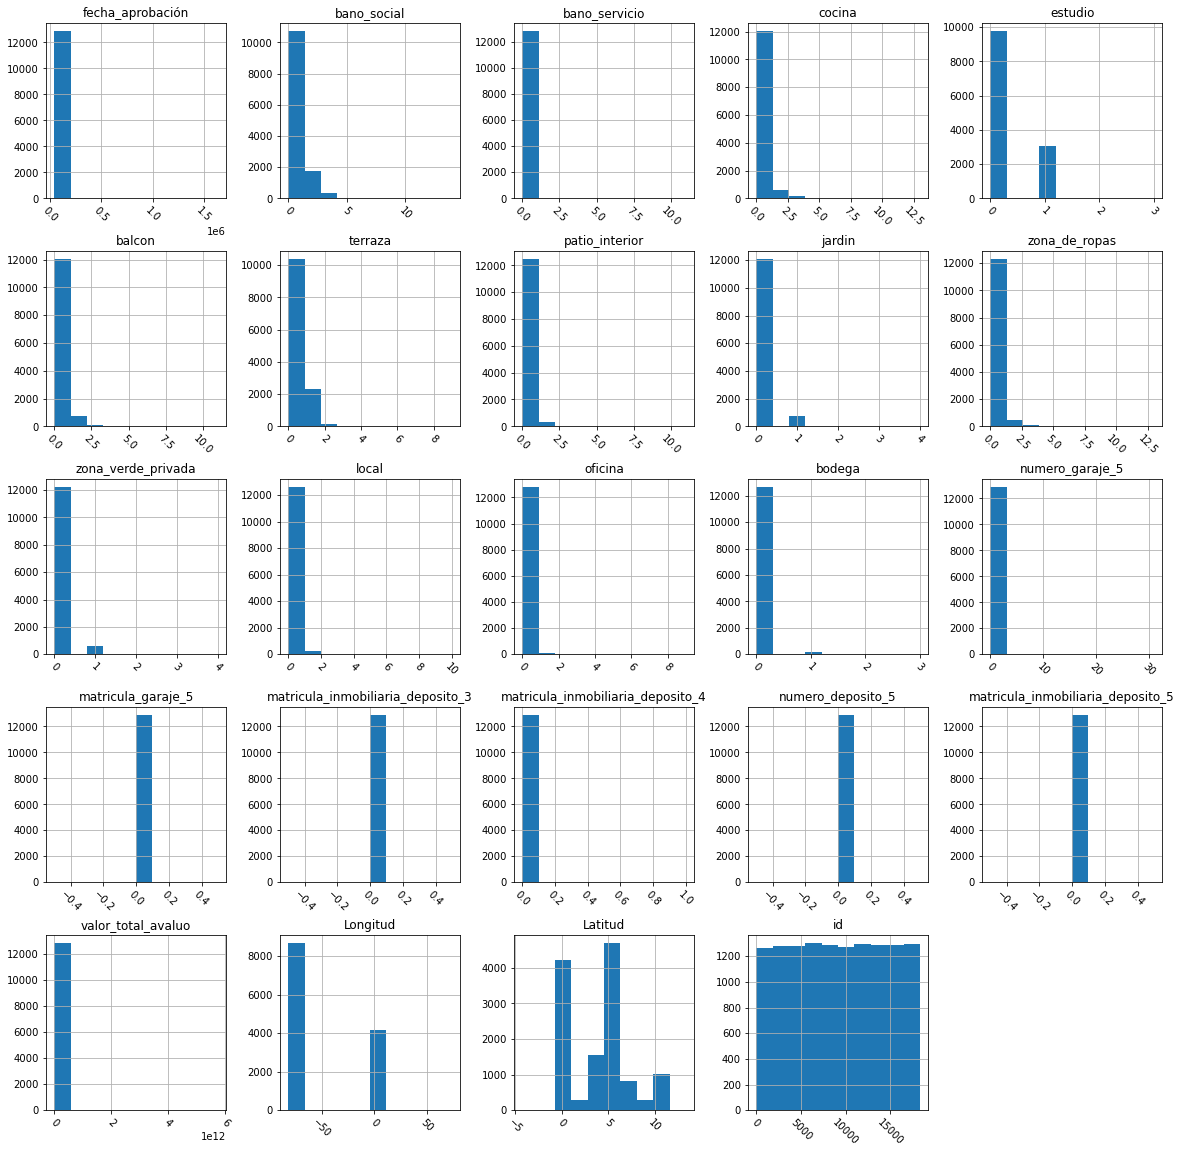

In [240]:
df_train.hist(figsize=(20,20), xrot=-45)
plt.show()

#### Visualizacion de la ubicación de las casas en funcion de la latitud y la longitud

<Figure size 1440x1440 with 0 Axes>

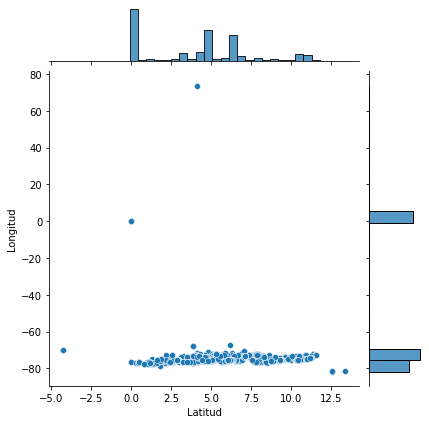

In [241]:
#Visualizacion de la ubicación de las casas en funcion de la latitud y la longitud
ubicacion = df_train[['Latitud', 'Longitud']]
plt.figure(figsize=(20,20))
sns.jointplot(x="Latitud", y="Longitud", data=ubicacion)
plt.show()

Podemos inferir de esta visualizacion que la mayor cantidad de inmuebles de ubica en una **latitud** que va de 0 a 7.5 y una **longitud** entre -70 y -85 aproximadamente.

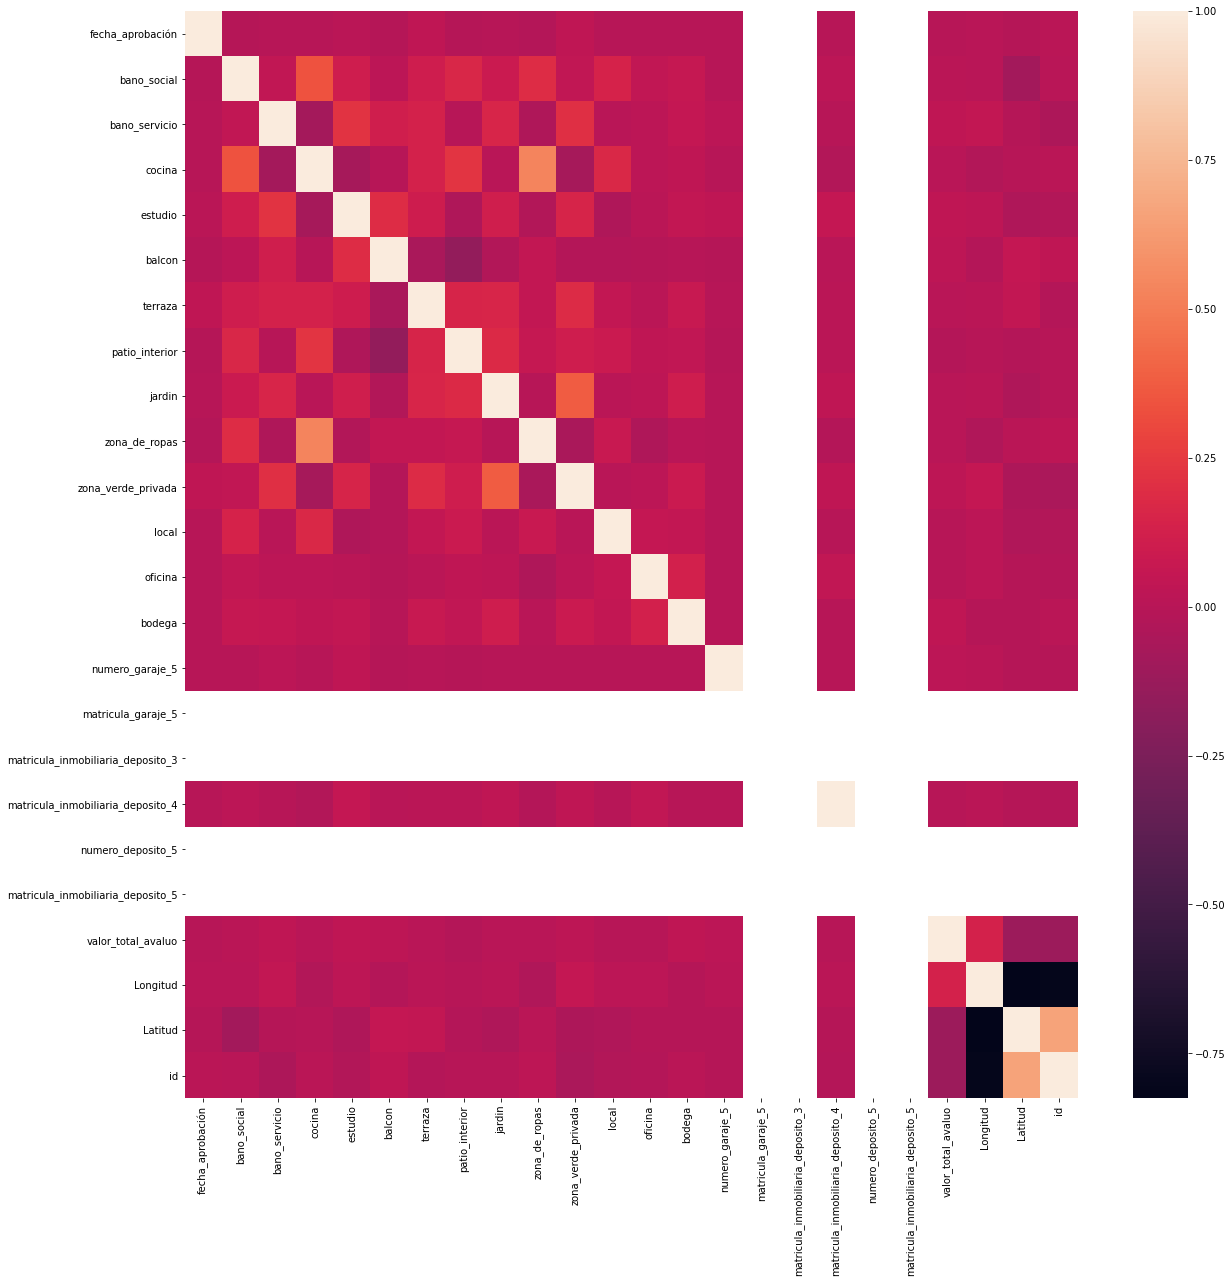

In [242]:
#Explorar correlacion en dataset
plt.figure(figsize=(20, 20))
sns.heatmap(df_train.corr())
plt.savefig("pearsonsmep.png")

El ***valor total del avaluo*** parece estar distribuido aproximadamente normalmente dentro de cada nivel de cada categoría. No aparecen observaciones, desfavorables. Algunas categorías contienen poca o ninguna información

### Transformación de Campos

In [243]:
#Se realiza una busqueda de aquellos campos textuales que no tienen mas de 15 valores diferentes.
df_caract = df_train.select_dtypes(include=["object"]).columns

for col in df_caract.tolist():
    arr = df_train[col].unique()[:15]
    if len(arr) < 15:        
        print("\nEstos son los diferentes valores que puede tomar la columna {}:\n".format(col))
        print(arr)


Estos son los diferentes valores que puede tomar la columna objeto:

['Originación' 'Remate' 'OriginaciÃ³n' '2018-06-19 19:48:27.269-05']

Estos son los diferentes valores que puede tomar la columna proposito:

['Garantía Hipotecaria' 'Transacción Comercial de Venta'
 'Valor Asegurable' 'GarantÃ\xada Hipotecaria'
 'TransacciÃ³n Comercial de Venta' '0' 'CrÃ©dito hipotecario de vivienda'
 'TransacciÃ³n Comercial de Renta']

Estos son los diferentes valores que puede tomar la columna tipo_avaluo:

['Hipotecario' 'Remates' 'GarantÃ\xada Hipotecaria']

Estos son los diferentes valores que puede tomar la columna tipo_credito:

['Vivienda' 'Diferente de Vivienda' '0' 'Hipotecario']

Estos son los diferentes valores que puede tomar la columna tipo_subsidio:

['No subsidio' 'VIS' 'Frech II' 'Gratuita' 'VIP' 'Vivienda']

Estos son los diferentes valores que puede tomar la columna sector:

['Urbano' 'Rural' 'Meseta de San Diego' 'Poblado del Hato' 'Villa Sofia'
 'Pie del Monte' 'LOS GIRASOLES' '


Estos son los diferentes valores que puede tomar la columna estado_acabados_metal:

['Bueno' 'Sencillo' 'Normal' 'Sin acabados' 'Sin Acabados' 'Regular'
 'Lujoso' 'Malo']

Estos son los diferentes valores que puede tomar la columna calidad_acabados_metal:

['Normal' 'Sencillo' 'Bueno' 'Sin Acabados' 'Lujoso' 'Regular']

Estos son los diferentes valores que puede tomar la columna estado_acabados_banos:

['Bueno' 'Regular' 'Sencillo' 'Normal' 'Sin acabados' 'Sin Acabados'
 'Malo' 'Lujoso']

Estos son los diferentes valores que puede tomar la columna calidad_acabados_banos:

['Normal' 'Sencillo' 'Bueno' 'Lujoso' 'Sin Acabados' 'Regular' 'Malo']

Estos son los diferentes valores que puede tomar la columna estado_acabados_cocina:

['Bueno' 'Regular' 'Sencillo' 'Normal' 'Sin acabados' 'Malo' 'Lujoso']

Estos son los diferentes valores que puede tomar la columna calidad_acabados_cocina:

['Integral' 'Sencillo' 'Semi-Integral' 'Bueno' 'Sin Acabados' 'Lujoso'
 'Normal' 'Regular']

Estos son lo

A partir de los resultados generados en la celda anterior, procedemos a transformar las variables que pueden llegar a impactar el valor del inmueble, ademas se tiene en cuenta la informacion consignada en ***metaData.pdf*** para dicha seleccion.

#### Variables categoricas

In [244]:
values_dico = {    
    'Si': 1, 
    'No': 0,
    '0': 0,
    '5.0010106160500402E+23':2,
    '37172': 3, 
    '4.3346261000000004': 4,
    'Media': 5,
    '5.0010105140699998E+23': 6
}
values_obj = {    
    'Originación': 0, 
    'Remate': 1 ,
    'OriginaciÃ³n': 2 ,
    '2018-06-19 19:48:27.269-05': 3
}
values_avaluo = {    
    'Hipotecario': 0,
    'Remates': 1, 
    'GarantÃ\xada Hipotecaria': 2
}
values_tipocred = {
    'Vivienda': 0, 
    'Diferente de Vivienda': 1, 
    '0': 2, 
    'Hipotecario': 3    
}
values_sub = {
    'VIS': 0,
    'Frech II': 1,
    'Gratuita': 2,
    'VIP': 3,
    'Vivienda': 4,
    'No subsidio': 5
}
values_sect = {    
    'Urbano': 0, 
    'Rural': 1, 
    'Meseta de San Diego': 2, 
    'Poblado del Hato': 3, 
    'Villa Sofia': 4,
    'Pie del Monte': 5, 
    'LOS GIRASOLES': 6, 
    'Poblado': 7, 
    'MEDELLIN': 8,
    'Urb. Tierra Prometida P.H.': 9,  
    'UrbanizaciÃ³n Los Alcores': 10,
    'Bifamiliar CortÃ©s': 11,
    'No sector': 12
}
values_estrat = {
    '2': 1, 
    '3': 2, 
    '5': 4, 
    '6': 5, 
    '4': 3,
    '1': 0,
    'Si': 6,
    'No': 7,
    'Oficina': 8,
    'Comercial': 9,  
    'Industrial': 10
}
values_topo = {
    'Plano': 0, 
    'Ligera': 1,    
    'Inclinado': 2, 
    'Accidentada': 3, 
    'Si': 4, 
    '6': 5
}
values_salub = {
    'Buenas': 0, 
    'Regulares': 1, 
    'Inclinado': 2, 
    'Ligera': 3, 
    'Malas': 4, 
    'Si': 5, 
    '3': 6, 
    'Plano': 7
}
values_trans = {
    'Bueno': 0, 
    'Regular': 1,
    'Buenas': 2, 
    'Malo': 3, 
    'Ligera': 4, 
    'Si': 5
}
values_demaninter = {
    'Media': 0, 
    'Fuerte': 1, 
    'Débil': 2, 
    'Nula': 3, 
    'Vivienda': 4, 
    'Hotelero': 5, 
    'Bueno': 6, 
    'Buenas': 7,
    'DÃ©bil': 8
}
values_parad = {
    'Si': 0, 
    'No': 1, 
    'Media': 2, 
    'Vivienda': 3, 
    'Bueno': 4, 
    'Fuerte': 5
}
values_nivelequi = {
    'Bueno': 0, 
    'Muy bueno': 1, 
    'Regular Malo': 2, 
    'En Proyecto': 3, 
    'No': 4, 
    'Si': 5
}
values_tel = {
    'No': 0,
    'Si': 1,
    '0': 2,
    '"OFERTA: MEDIA - DEMANDA: BAJA"': 3
}
values_tipo_inmueble = {    
    'Casa': 0,
    'Apartamento': 1, 
    'Finca': 2, 
    'Si': 3, 
    'No': 4, 
    'Lote': 5, 
    'Casa Rural': 6,
    'Conjunto o Edificio': 7, 
    'Garaje': 8, 
    'Lote Urbano': 9, 
    'DepÃ³sito': 10, 
    '0': 11, 
    'Oficina': 12
}
values_altura = {
    'Aplica': 1,
    'No Aplica': 0, 
    'Resultante': 2, 
    '0': 0, 
    'Si': 1, 
    'No': 0, 
    'SinOcupante': 3,
    'Unifamiliar': 4, 
    'Propietario': 5, 
    'terraza cubierta y descubierta': 6
}
values_antejar = {
    'Aplica': 1, 
    'No Aplica': 0, 
    '0': 0,
    '2': 2,
    '3': 3
}
values_aislposte = {
    'Aplica': 1,
    'No Aplica': 0, 
    '3': 3, 
    '0': 0, 
    '2': 2, 
    'SinOcupante': 4, 
    'Si': 1, 
    '4': 4, 
    '1': 1, 
    'No': 0
}
values_aislate = {
    'Aplica': 1, 
    'No Aplica': 0, 
    '0': 0, 
    '3': 3, 
    '2': 2
}
values_indocup = {
   'Aplica': 1, 
   'Resultante': 2, 
   '0': 0, 
   'No Aplica': 0, 
   '1,8': 1.8, 
   '2': 2, 
   '2,5': 2.5, 
   '3': 3, 
   '1,5': 1.5, 
   '3.5': 3.5
}
values_indconstr = {   
    'Aplica': 1, 
    'No Aplica': 0, 
    'Resultante': 2, 
    '0': 0, 
    '0,14': 0.14, 
    '1,5': 1.5, 
    '0,6': 0.6, 
    '0,7': 0.7,
    '1': 1, 
    '0,8': 0.8,
    '0,875': 0.875, 
    '0.75': 0.75,     
}
values_pis = {
    'No': 0, 
    '0': 0, 
    'Si': 1, 
    'MULTIHABITACIONAL': 2, 
    'Vivienda': 3, 
    'R-2': 4
}

values_garaj= {
    'No Tiene': 0,
    'Privado': 1, 
    'Exclusivo': 2,
    'Comunal': 3, 
    'Semi-Integral': 4, 
    'Sencillo': 5,    
    'Bueno': 6, 
    'Integral': 7, 
    'Normal': 8,
    'Regular': 9,
    'Lujoso': 10,
    'Sin acabados': 11,
    'Sin Acabados': 11
}

#Variable cuasi-dicotomicas
list_dico = ['alcantarillado_en_el_sector', 'acueducto_en_el_sector', 'gas_en_el_sector', 'energia_en_el_sector', 
             'telefono_en_el_sector', 'vias_pavimentadas', 'sardineles_en_las_vias', 'andenes_en_las_vias', 'teatrino', 
             'garaje_visitantes', 'club_house', 'sauna', 'vigilancia_privada', 'ciclo_rutas', 'arborizacion']

for col in list_dico:
    df_train[col] = df_train[col].map(values_dico)
    
#Objeto
df_train['objeto'] = df_train['objeto'].map(values_obj)

#Values avaluo
df_train['tipo_avaluo'] = df_train['tipo_avaluo'].map(values_avaluo)

#tipo credito
df_train['tipo_credito'] = df_train['tipo_credito'].map(values_tipocred)

#tipo subsidio
df_train['tipo_subsidio'] = df_train['tipo_subsidio'].map(values_sub)

#sector
df_train['sector'] = df_train['sector'].map(values_sect)

#estrato
df_train['estrato'] = df_train['estrato'].map(values_estrat)

#topografia
df_train['topografia_sector'] = df_train['topografia_sector'].map(values_topo)

#salubridad
df_train['condiciones_salubridad'] = df_train['condiciones_salubridad'].map(values_salub)

#transporte
df_train['transporte'] = df_train['transporte'].map(values_trans)

#demanda interes
df_train['demanda_interes'] = df_train['demanda_interes'].map(values_demaninter)

#paradero
df_train['paradero'] = df_train['paradero'].map(values_parad)

#alamedas
df_train['alamedas'] = df_train['alamedas'].map(values_dico)

#nivel_equipamiento_comercial
df_train['nivel_equipamiento_comercial'] = df_train['nivel_equipamiento_comercial'].map(values_nivelequi)

#telefono_en_el_predio
df_train['telefono_en_el_predio'] = df_train['telefono_en_el_predio'].map(values_tel)

#tipo inmueble
df_train['tipo_inmueble'] = df_train['tipo_inmueble'].map(values_tipo_inmueble)

#altura_permitida
df_train['altura_permitida'] = df_train['altura_permitida'].map(values_altura)

#antejardin
df_train['antejardin'] = df_train['antejardin'].map(values_antejar)

#aislamiento_posterior
df_train['aislamiento_posterior'] = df_train['aislamiento_posterior'].map(values_aislposte)

#aislamiento_lateral
df_train['aislamiento_lateral'] = df_train['aislamiento_lateral'].map(values_aislate)

#indice_ocupacion
df_train['indice_ocupacion'] = df_train['indice_ocupacion'].map(values_indocup)

#indice_construccion
df_train['indice_construccion'] = df_train['indice_construccion'].map(values_indocup)

#piscina
df_train['piscina'] = df_train['piscina'].map(values_pis)

#tipo_garaje
df_train['tipo_garaje'] = df_train['tipo_garaje'].map(values_garaj)

#Limpiar algunas variables numericas que tiene valores de cadena
def clean(val):    
    try:
        val = int(val)        
    except:
        val = 1
    finally:
        return val           

vbles = ['closet', 'sala', 'comedor', 'bano_privado', 'habitaciones']     
for col in vbles:
    df_train[col] = df_train[col].apply(clean)

In [245]:
#Imputacion indice_construccion
valores = {
    "indice_construccion": df_train['indice_construccion'].mode()[0]    
}
df_train.fillna(value=valores, inplace=True)
campos_nan(df_train)

No se encontraron campos con registros nan.


In [246]:
print(len(df_train._get_numeric_data().columns.tolist()))

67


Pasamos de tener 24 variables numericas a tener 67, se realizara una seleccion de caracteristicas para obtener las variables mas importantes para el modelo.

In [248]:
df_base = df_train

In [118]:
#Division de los sets de entranamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_train._get_numeric_data(), df_train['valor_total_avaluo'],test_size = 0.2, random_state = 123) 

#Mostrar resultados del split 
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 10285 samples.
Testing set has 2572 samples.


### Selección de caracteristicas

In [119]:
# Import Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y_train)

# Train the supervised model on the training 
model = AdaBoostClassifier().fit(X_train, encoded)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

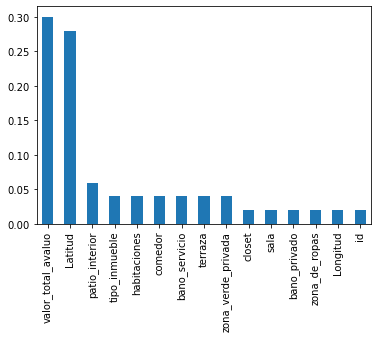

In [125]:
feat_importances = pd.Series(model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(15).plot.bar()
plt.show()

- Luego de realizar el analisis y transformacion de la información se puede evidenciar que la informacion de algunas varibles en especial las categoricas, estas tienen diferentes valores e inclusive algunas varibles tienen valores numericos y cadenas, imposibilitando la interpretacion de algunas variables, es importante estandarizar dichos campos y conservar su integridad, ya que al realizar la seleccion de caracteristicas estos pueden ser filtrados.

- Para continuar en la etapa de modelamiento, vamos a tomar un dataset con las 15 caracteristicas seleccionadas.

### Dataset Final

In [249]:
df_base = df_base[['valor_total_avaluo', 'patio_interior', 'tipo_inmueble', 'habitaciones', 'comedor', 'bano_servicio','terraza', 'zona_verde_privada', 'closet', 'sala', 'bano_privado','zona_de_ropas', 'Longitud', 'Latitud','id']]
df_base.head(10)

valor_total_avaluo  patio_interior  tipo_inmueble  habitaciones  comedor  \
0        7.199550e+09               0              0             3        1   
1        8.709400e+09               1              0             4        1   
2        7.615150e+09               0              1             3        1   
3        7.809000e+08               0              0             3        1   
4        6.120500e+09               2              0             3        1   
5        1.648560e+12               0              1             3        1   
6        2.155032e+10               1              0             3        1   
7        9.661000e+07               1              0             4        1   
8        1.608208e+10               0              1             3        1   
9        8.800000e+07               1              0             3        1   

   bano_servicio  terraza  zona_verde_privada  closet  sala  bano_privado  \
0              0        0                   0       0     1             0   
1              0        1                   0       0     1             2   
2              0        0                   0       3     1             0   
3              0        1                   0       0     1             1   
4              0        0                   0       0     1             1   
5              0        0                   0       0     1             2   
6              0        0                   0       3     1             1   
7              0        0                   0       0     1             1   
8              1        0                   0       3     1             1   
9              0        0                   0       0     1             0   

   zona_de_ropas  Longitud  Latitud  id  
0              1       0.0      0.0   1  
1              1       0.0      0.0   3  
2              1       0.0      0.0   4  
3              1       0.0      0.0   5  
4              1       0.0      0.0   6  
5              1       0.0      0.0   7  
6              1       0.0      0.0   8  
7              1       0.0      0.0  10  
8              1       0.0      0.0  11  
9              1       0.0      0.0  12

In [250]:
#Serializacion del dataframe
with open('df_base.pickle', 'wb') as output:
    pickle.dump(df_base, output)